# Python Session 5: Introduction to Recurrent neural networks

# RNN

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

## 5.1. Data preparation

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os

os.chdir("/content/gdrive/MyDrive/Colab Notebooks")

In [4]:
df = pd.read_csv("kospi.csv")

In [5]:
df.head() #과거data를 가지고 내일의 Volume을 예측

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,2183.489990,2206.199951,2177.879883,2206.199951,2206.199951,480400
1,2019-01-31,2222.879883,2222.879883,2201.219971,2204.850098,2204.850098,545200
2,2019-02-01,2211.929932,2218.780029,2201.409912,2203.459961,2203.459961,479400
3,2019-02-07,2215.770020,2215.790039,2196.770020,2203.419922,2203.419922,427800
4,2019-02-08,2192.010010,2192.479980,2171.959961,2177.050049,2177.050049,391000


In [6]:
scaler = MinMaxScaler()
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])

In [7]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,0.722898,0.732351,0.745525,0.759235,2206.199951,0.242113
1,2019-01-31,0.763058,0.750069,0.769089,0.757866,2204.850098,0.274771
2,2019-02-01,0.751894,0.745714,0.769280,0.756456,2203.459961,0.241609
3,2019-02-07,0.755809,0.742538,0.764596,0.756415,2203.419922,0.215603
4,2019-02-08,0.731584,0.717777,0.739548,0.729669,2177.050049,0.197057


In [8]:
X = df[['Open','High','Low','Close', "Volume"]].values
y = df['Volume'].values

In [9]:
print(X.shape, y.shape)

(431, 5) (431,)


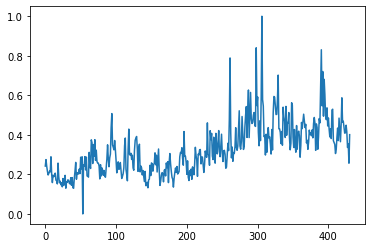

In [10]:
plt.plot(X[:, -1])

Now you create the data for many-to-many train where input has length `sequence_length` and output has length `sequence_length`.

In [11]:
def seq_data(x, y, sequence_length):
    
    x_seq = []
    y_seq = []
    for i in range(len(x)-sequence_length):
        x_seq.append(x[i:i+sequence_length])         #1~21, 2~22 
        y_seq.append(y[(i+1):(i+sequence_length+1)]) #2~22, 3~23
    
    return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32) #.view([-1,sequence_length]) 

In [12]:
sequence_length = 50
x_seq, y_seq = seq_data(X, y, sequence_length)
print(x_seq.shape, y_seq.shape)

torch.Size([381, 50, 5]) torch.Size([381, 50])


<ipython-input-11-0fc7f7070eea>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32) #.view([-1,sequence_length])


In [ ]:
split = 200

x_seq, y_seq = seq_data(X, y, sequence_length)
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size()) # [n, T, p], [n, T]
print(x_test_seq.size(), y_test_seq.size()) # [n, T, p], [n,T]

torch.Size([200, 50, 5]) torch.Size([200, 50])
torch.Size([181, 50, 5]) torch.Size([181, 50])


In [ ]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=True)

## 5.2. Define RNN

In [ ]:
# RNN
input_size = x_seq.shape[2]
num_layers = 2
hidden_size = 8

print(input_size)

5


### First, we play with `torch.nn.RNN` layer:
* Inouts:
  * input_size – The number of expected features in the input x

  * hidden_size – The number of features in the hidden state h

  * num_layers – Number of recurrent layers stacked vertically.
  
* Default dimension of input is `[Seq_len, Batch_size, Input_size]`. If `batch_first=True`, then dimension of input becomes `[Batch_size, Seq_len, Input_size]`. 

* Dimension of h0 is `[num_layers * num_directions, batch, hidden_size]`  which is irrelevant to `Input_size`, and also invariant to `batch_first=True`.

### 5.2.1. `nn.RNN` with `batch_first = True`

# Here goes RNN figure

<img src="https://drive.google.com/uc?export=view&id=1N8Qx5Qp0-xiwJGvGsq2A9tfP9r_r5-f-" width=600, height=300>


$W0_{hh}$: [H, H] and $W0_{xh}$: [D, H] and $b0_h$: [H,]

$W1_{hh}$: [H, H] and $W1_{xh}$: [H, H] and $b1_h$: [H,]


<img src="https://drive.google.com/uc?export=view&id=1NDdcajB-6CBPiFqhB0jzkrAgnVQFAYgc" width=700, height=400>



In [ ]:
torch.manual_seed(1)
toy_rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

In [ ]:
h0 = torch.zeros(num_layers, x_train_seq.shape[0], hidden_size)# [num_layers, batch_size, hidden_size]

out, hn = toy_rnn(x_train_seq, h0) #input(x_train_seq): [batch_size, seq_len, input_size]
                                   #h0: [num_layers, batch_size, hidden_size]

In [ ]:
print(out.shape, hn.shape, h0.shape)

torch.Size([200, 50, 8]) torch.Size([2, 200, 8]) torch.Size([2, 200, 8])


In [ ]:
out[:1, 0, :5]

tensor([[-0.1120,  0.4910,  0.0290,  0.1342, -0.0008]],
       grad_fn=<SliceBackward0>)

In [ ]:
for name, weight in toy_rnn.named_parameters():
  print(name)

# Question: why do we have two bias for each rnn layer?
# Answer: Not necessarily.

weight_ih_l0
weight_hh_l0
bias_ih_l0
bias_hh_l0
weight_ih_l1
weight_hh_l1
bias_ih_l1
bias_hh_l1


In [ ]:
toy_rnn.weight_ih_l0 # shape: [input_size, H]

Parameter containing:
tensor([[ 0.1822, -0.1561, -0.0685,  0.1659, -0.3328],
        [ 0.2120, -0.0727,  0.1799,  0.0491, -0.0433],
        [ 0.0981,  0.0174,  0.1291, -0.1378, -0.0258],
        [-0.0318,  0.0512, -0.0014,  0.3091,  0.1100],
        [-0.1317, -0.2135, -0.0593, -0.1525, -0.1133],
        [ 0.0169,  0.2108,  0.1922, -0.3456,  0.2192],
        [ 0.0988,  0.3354,  0.2334, -0.3221, -0.3362],
        [-0.1705,  0.3105, -0.0589,  0.1513, -0.1643]], requires_grad=True)

In [ ]:
toy_rnn.weight_ih_l1 # shape: [H, H]

Parameter containing:
tensor([[-0.2138,  0.0444,  0.3524, -0.2233,  0.1884, -0.1957, -0.3324, -0.0751],
        [ 0.2037,  0.3282, -0.2196,  0.0767,  0.3051,  0.2343,  0.2203,  0.2512],
        [ 0.2236,  0.0913, -0.2418, -0.2969, -0.1620, -0.0412, -0.2167,  0.1293],
        [ 0.1094, -0.0801,  0.1359,  0.1143,  0.2159,  0.2381, -0.1197,  0.3454],
        [-0.0409, -0.0121, -0.3337, -0.2276, -0.2065, -0.1512,  0.2514, -0.1155],
        [-0.2642,  0.1360,  0.1132,  0.2290, -0.1830,  0.0767, -0.1287, -0.0794],
        [-0.2818, -0.1611, -0.1083,  0.1512,  0.0646,  0.0873,  0.3529,  0.3446],
        [ 0.2411,  0.0113, -0.2446,  0.2763, -0.0884, -0.0286, -0.3046, -0.0698]],
       requires_grad=True)

### Exercise 5.2.1.1

Calculate `out[0, -1, :]` out  of [N,T,H ] dimensional data and 
`hn[-1, 0, :]` out of [2, N, H] dimensional hidden state. 

Answer the following questions.

1> Are they the same? why? Where are they in the figure?

2> Where is hn[0, 0, :] in the figure?

In [ ]:
print(out[0, -1, :], hn[-1, 0, :])

tensor([-0.0672,  0.4585, -0.1295,  0.4709,  0.0490,  0.4619, -0.1149,  0.1329],
       grad_fn=<SliceBackward0>) tensor([-0.0672,  0.4585, -0.1295,  0.4709,  0.0490,  0.4619, -0.1149,  0.1329],
       grad_fn=<SliceBackward0>)


### 5.2.2. (Study by yourself.)  `nn.RNN` with `batch_first = False`

(This method is not recommended in this class This section is just for comparison purpose)

The dimension of x_train should be transposed. Specifically, 0-th dimension (batch) and 1-st dimension (time) should be transposed.

In [ ]:
x_train_seq_transpose = torch.transpose(x_train_seq, 0, 1)
# Caution: do not use x_train_seq.reshape()  Why?
x_train_seq_transpose.shape

torch.Size([50, 200, 5])

### Example 5.2.2.1

Play with the following example:

Person 0: (21, 100, 1) in Year 1,  (22, 110, 1) in Year 2

Person 1: (41, 150, 0) in Year 1,  (42, 140, 0) in Year 2

## Now, let's continue to define recurrent unit and check the outputs.

In [ ]:
torch.manual_seed(1)
toy_rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=False) # batch_first=False

h0 = torch.zeros(num_layers, x_train_seq.shape[0], hidden_size)# [num_layers, batch_size, hidden_size], same as before
out, hn = toy_rnn(x_train_seq_transpose, h0) #input(x_train_seq): [seq_len, batch_size, input_size], Changed!!!!!!!
                                             #h0: [num_layers, batch_size, hidden_size], same as before

In [ ]:
print(out.shape, hn.shape, h0.shape)

torch.Size([50, 200, 8]) torch.Size([2, 200, 8]) torch.Size([2, 200, 8])


In [ ]:
x_train_seq.shape

torch.Size([200, 50, 5])

In [ ]:
out[0, :1, :5]

tensor([[-0.1120,  0.4910,  0.0290,  0.1342, -0.0008]],
       grad_fn=<SliceBackward0>)

### 5.2.3. Define RNNs.

In [ ]:
class many_to_many_rnn(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers):
        super(many_to_many_rnn, self).__init__()
        self.hidden_size = hidden_size #8
        self.num_layers = num_layers #2
        ########################################################################
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        #Then rnn handle the data of dimension [:, T, input_size]
        ########################################################################
        self.fc = nn.Sequential(nn.Linear(hidden_size, 1), nn.Sigmoid())
        
    def forward(self, x):
        #many-to-many
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size)# [num_layers, n, num_hidden]
        # (num_layers, batch_size, hidden_size)

        out, hn = self.rnn(x, h0) # many-to-many, #out: hidden state of top layer, hn: hidden state of middle layers
        #out: [:, T, hidden_size]
        out = self.fc(out) # many-to-many (defined by matrix multiplication)
        
        # For many-to-one: see the code below:
        # h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(self.device) # [num_layers, n, num_hidden]
        # out, hn = self.rnn(x, h0) # many-to-many, #out: hidden state of top layer, hn: hidden state of middle layers
        # #out: [:, T, hidden_size]
        # many_to_one_out = out[:,-1,:] #[:,hidden_size] 
        # many_to_one_out = self.fc(many_to_one_out) 


        return out

In [ ]:
model = many_to_many_rnn(input_size=input_size, 
                   hidden_size=hidden_size,  
                   num_layers=num_layers)

In [ ]:
print(model)

many_to_many_rnn(
  (rnn): RNN(5, 8, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [ ]:
y_test_hat = model(x_test_seq)
print(y_test_hat.shape, y_test_seq.shape)


torch.Size([181, 50, 1]) torch.Size([181, 50])


Now we define the loss function and train the model.

In [ ]:
def criterion_many_to_many(y_pred, y_true):
  #y_pred: [:, T, 1]
  #y_true: [:,T]
  return torch.mean((y_pred[:,:,0]-y_true)**2)

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)


In [ ]:
loss_graph = []
n = len(train_loader)
print(n)
num_epochs=5000
for epoch in range(num_epochs):
    running_loss = 0.0
    
    for seq, target in train_loader:
        #print(target.shape)
        out = model(seq)
        loss = criterion_many_to_many(out, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    loss_graph.append(running_loss/n)
    if epoch % 100 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

7
[epoch: 0] loss: 0.0794
[epoch: 100] loss: 0.0051
[epoch: 200] loss: 0.0050
[epoch: 300] loss: 0.0033
[epoch: 400] loss: 0.0031
[epoch: 500] loss: 0.0028
[epoch: 600] loss: 0.0026
[epoch: 700] loss: 0.0023
[epoch: 800] loss: 0.0020
[epoch: 900] loss: 0.0019
[epoch: 1000] loss: 0.0019
[epoch: 1100] loss: 0.0017
[epoch: 1200] loss: 0.0016
[epoch: 1300] loss: 0.0015
[epoch: 1400] loss: 0.0015
[epoch: 1500] loss: 0.0014


KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show() 

In [ ]:
y_hat_seq = model(torch.tensor(X[np.newaxis, :,:], dtype=torch.float32))
print(y_hat_seq.shape)
plt.plot(y_hat_seq[0,:,0].detach().numpy())

In [ ]:
X[np.newaxis, :,:].shape

In [ ]:
y_hat_seq = model(torch.tensor(X[np.newaxis, :,:], dtype=torch.float32))
print(y_hat_seq.shape)
#plt.plot(y)
plt.plot(y_hat_seq[0,:,0].detach().numpy())
plt.plot(X[:, -1], color="k")

# It seems that prediction is not very precise.

In [ ]:
X.shape

### Exercise 5.3.1.1: 

In the above example, you can play with many-to-one loss function. Using the following data, train the many-to-one RNNs by modifying the above code. After train, compare the prediction ability of two models by comparing Test MSE using `test_loader_one` defined below.

In [ ]:
print(x_train_seq.size(), y_train_seq.size()) # [n, T, p], [n, T]
print(x_test_seq.size(), y_test_seq.size()) # [n, T, p], [n,T]

torch.Size([200, 6, 5]) torch.Size([200, 6])
torch.Size([225, 6, 5]) torch.Size([225, 6])


In [ ]:
train_one = torch.utils.data.TensorDataset(x_train_seq, y_train_seq[:, -1:])
test_one = torch.utils.data.TensorDataset(x_test_seq, y_test_seq[:, -1:])

batch_size = 32
train_loader_one = torch.utils.data.DataLoader(dataset=train_one, batch_size=batch_size, shuffle=True)
test_loader_one = torch.utils.data.DataLoader(dataset=test_one, batch_size=batch_size, shuffle=True)

### Exercise 5.3.1.2:

In the above many-to-many example, we vertically stacked two recurrent units having identical size `H` of `hidden_layer`. Now, you want to stack two recurrent units vertically having two different sizes `H` of `hidden_layer`s. Define the model, and properly train. (You may want to use many-to-many loss function while many-to-one is also possible.)

### Exercise 5.3.1.3:

Input_size was 5 in the above example. Now, use volume only to predict volume using RNNs with many-to-many loss function. With the trained model, use `X[:300, -1]` to predict `X[300:, -1]`, and validate your prediction by drawing graph.

## 5.3. LSTM

<img src="https://drive.google.com/uc?export=view&id=1NK6v1JYU-A09J96rJNH0rOMSbR7o5jhX" width=700, height=400>

In [ ]:
hidden_size=4

In [ ]:
torch.manual_seed(1)
toy_lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

h0 = torch.zeros(num_layers, x_train_seq.shape[0], hidden_size)
c0 = torch.zeros(num_layers, x_train_seq.shape[0], hidden_size)
out, (hn, cn) = toy_lstm(x_train_seq, (h0, c0)) 

In [ ]:
print(out.shape, hn.shape, cn.shape)

torch.Size([200, 50, 4]) torch.Size([2, 200, 4]) torch.Size([2, 200, 4])


In [ ]:
x_train_seq.shape

torch.Size([200, 50, 5])

In [ ]:
class many_to_many_LSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers):
        super(many_to_many_LSTM, self).__init__()
        self.hidden_size = hidden_size #8
        self.num_layers = num_layers #2
        ########################################################################
        self.LSTM = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        #Then rnn handle the data of dimension [:, T, input_size]
        ########################################################################
        self.fc = nn.Sequential(nn.Linear(hidden_size, 1), nn.Sigmoid())
        
    def forward(self, x):
        #many-to-many
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size)# [num_layers, n, num_hidden]
        c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size)# [num_layers, n, num_hidden]        

        # (num_layers, batch_size, hidden_size)

        out, (hn, cn) = self.LSTM(x, (h0, c0)) # many-to-many, #out: hidden state of top layer, (hn, cn): hidden state of middle layers
        #out: [:, T, hidden_size]
        out = self.fc(out) # many-to-many (defined by matrix multiplication)

        return out

In [ ]:
model = many_to_many_LSTM(input_size=input_size, 
                   hidden_size=hidden_size,  
                   num_layers=num_layers)

In [ ]:
def criterion_many_to_many(y_pred, y_true):
  #y_pred: [:, T, 1]
  #y_true: [:,T]
  return torch.mean((y_pred[:,:,0]-y_true)**2)

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)


In [ ]:
loss_graph = []
n = len(train_loader)
print(n)
num_epochs=4000
for epoch in range(num_epochs):
    running_loss = 0.0
    
    for seq, target in train_loader:
        #print(target.shape)
        out = model(seq)
        loss = criterion_many_to_many(out, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    loss_graph.append(running_loss/n)
    if epoch % 100 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

7
[epoch: 0] loss: 0.0410
[epoch: 100] loss: 0.0053
[epoch: 200] loss: 0.0051
[epoch: 300] loss: 0.0049
[epoch: 400] loss: 0.0048
[epoch: 500] loss: 0.0037
[epoch: 600] loss: 0.0033
[epoch: 700] loss: 0.0031
[epoch: 800] loss: 0.0032
[epoch: 900] loss: 0.0031
[epoch: 1000] loss: 0.0031
[epoch: 1100] loss: 0.0031
[epoch: 1200] loss: 0.0031
[epoch: 1300] loss: 0.0030
[epoch: 1400] loss: 0.0029
[epoch: 1500] loss: 0.0028
[epoch: 1600] loss: 0.0027
[epoch: 1700] loss: 0.0026
[epoch: 1800] loss: 0.0027
[epoch: 1900] loss: 0.0025
[epoch: 2000] loss: 0.0025
[epoch: 2100] loss: 0.0024
[epoch: 2200] loss: 0.0024
[epoch: 2300] loss: 0.0023
[epoch: 2400] loss: 0.0022
[epoch: 2500] loss: 0.0021
[epoch: 2600] loss: 0.0021
[epoch: 2700] loss: 0.0020
[epoch: 2800] loss: 0.0019
[epoch: 2900] loss: 0.0019
[epoch: 3000] loss: 0.0019
[epoch: 3100] loss: 0.0018
[epoch: 3200] loss: 0.0018
[epoch: 3300] loss: 0.0018
[epoch: 3400] loss: 0.0017
[epoch: 3500] loss: 0.0017
[epoch: 3600] loss: 0.0017
[epoch: 370

In [ ]:
len(loss_graph)

4000

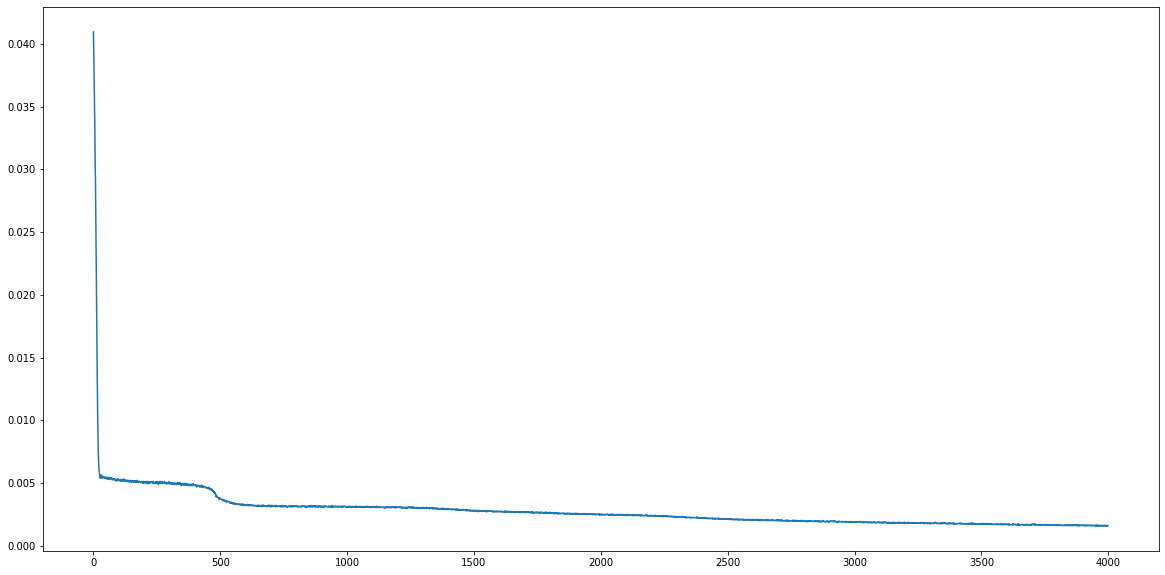

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show() 

torch.Size([1, 431, 1])


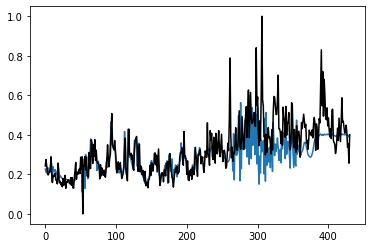

In [ ]:
y_hat_seq = model(torch.tensor(X[np.newaxis, :,:], dtype=torch.float32))
print(y_hat_seq.shape)
#plt.plot(y)
plt.plot(y_hat_seq[0,:,0].detach().numpy())
plt.plot(X[:, -1], color="k")

# It seems that long prediction is not very precise.

## 5.4 Application of RNNs into insurance forecasting

In [ ]:
'''
X
'''

np.random.seed(2022)
nYear=11
sample_size=150000
param_beta = np.array([-3.0, 1.0, 2.5])
p = len(param_beta) # number of explanatory variable including 1
para = pd.Series({'beta': param_beta, 'phi': 0.9, 'sig': 0.5})

X1 = np.stack((np.repeat(1, sample_size),
              np.random.binomial(n=1, p=0.5, size=sample_size),
              np.random.binomial(n=1, p=0.5, size=sample_size)),
              axis=1)

X0 = X1[:,1:] #not used
X_sim = np.stack([X1]*nYear, axis=1) #not used
X_sim.shape #not used

(150000, 11, 3)

In [ ]:
lamb = np.exp(np.matmul(X_sim, para['beta'][:, np.newaxis]))
print('lamb shape', lamb.shape)


lamb shape (150000, 11, 1)


In [ ]:
'''
lambda, R, n
'''


sig = para['sig']
phi = para['phi']
n = np.full((sample_size, nYear), 999)
Rhat = np.full((sample_size, nYear), 0.0)
c_mean=-sig/np.sqrt(1-phi**2)/2
for i in range(sample_size):
    for t in range(nYear):
        if t==0:
            Rhat[i,t] = np.random.normal(c_mean, sig/np.sqrt(1-phi**2), size=1) #= phi*R0[i] + epsilon[i,1]
        else:
            Rhat[i,t] = np.random.normal((Rhat[i,t-1]-c_mean)*phi, sig, size=1) +c_mean
            
        n[i,t] = np.random.poisson(lam=lamb[i,t]*np.exp(Rhat[i,t]), size=1) #rpois(1, mu_n )



N_sim=n
lamb_sim = lamb

print('N_sim shape', N_sim.shape)
print('lamb_sim shape', lamb_sim.shape) # lamb 복제 (nYear만큼)

N_sim shape (150000, 11)
lamb_sim shape (150000, 11, 1)


# You are given the following data

1. N_sim: claim history of size [sample_size, 11] 
2. lamb_sim: true priori rate of size [sample_size, 11, 1]
3. X_sim: explanatory variables of size [sample_size, 11, 3]

In [ ]:
print(N_sim.shape, lamb_sim.shape, X_sim.shape)

(150000, 11) (150000, 11, 1) (150000, 11, 3)


In [ ]:
np.unique(lamb_sim)

array([0.04978707, 0.13533528, 0.60653066, 1.64872127])

## Preprocessing

## Our goal is to make the following data:

y_future_train:  T2~T11 [N1, T, 1]

lamb_future_train:  T2~T11 [N1, T, 1]

lamb_current_train: T1~T10 [N1, T, 1]

y_future_valid:  T2~T11 [N2, T, 1]

lamb_future_valid:  T2~T11 [N2, T, 1]

lamb_current_valid: T1~T10 [N2, T, 1]

y_future_test:  T2~T11 [N3, T, 1]

lamb_future_test:  T2~T11 [N3, T, 1]

lamb_current_test: T1~T10 [N3, T, 1]




In [ ]:
sample_size

150000

In [ ]:
Y = torch.tensor(N_sim[:,:,np.newaxis ], dtype=torch.float32) #shape: [none, 11, 1], #time t1~t11
LAMB = torch.tensor(lamb_sim, dtype=torch.float32)

N_train = int(sample_size*0.5)
N_valid = int(sample_size*0.6)
N_test  = int(sample_size*1.0)

y_future_train, lamb_future_train, y_current_train, lamb_current_train =  Y[:N_train, 1:, :], LAMB[:N_train, 1:, :], Y[:N_train,:-1, :], LAMB[:N_train,:-1, :]
y_future_valid, lamb_future_valid, y_current_valid, lamb_current_valid =  Y[N_train:N_valid, 1:, :], LAMB[N_train:N_valid, 1:, :], Y[N_train:N_valid,:-1, :], LAMB[N_train:N_valid,:-1, :]
y_future_test, lamb_future_test, y_current_test, lamb_current_test =  Y[N_valid:, 1:, :], LAMB[N_valid:, 1:, :], Y[N_valid:,:-1, :], LAMB[N_valid:,:-1, :]


In [ ]:
x_current_train = torch.concat([y_current_train, lamb_current_train], axis=2)
x_current_valid = torch.concat([y_current_valid, lamb_current_valid], axis=2)
x_current_test = torch.concat([y_current_test, lamb_current_test], axis=2)

In [ ]:
x_current_test.shape

torch.Size([60000, 10, 2])

## Model definition

In [ ]:
train = torch.utils.data.TensorDataset(x_current_train, lamb_future_train, y_future_train)
test = torch.utils.data.TensorDataset(x_current_test, lamb_future_test, y_future_test)

batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=True)

In [ ]:
class forecasting(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers):
        super(forecasting, self).__init__()
        self.hidden_size = hidden_size #8
        self.num_layers = num_layers #2
        ########################################################################
        self.LSTM = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        #Then rnn handle the data of dimension [:, T, input_size]
        ########################################################################
        self.fc = nn.Sequential(nn.Linear(hidden_size, 1), nn.ReLU())
        
    def forward(self, x1, x2):
        # x2: lambda
        #many-to-many
        h0 = torch.zeros(self.num_layers, x1.shape[0], self.hidden_size)# [num_layers, n, num_hidden]
        c0 = torch.zeros(self.num_layers, x1.shape[0], self.hidden_size)# [num_layers, n, num_hidden]        

        # (num_layers, batch_size, hidden_size)

        out, (hn, cn) = self.LSTM(x1, (h0, c0)) # many-to-many, #out: hidden state of top layer, (hn, cn): hidden state of middle layers
        #out: [:, T, hidden_size]
        out = self.fc(out)*x2 # many-to-many (defined by matrix multiplication)

        return out

In [ ]:
input_size=2
hidden_size=4
num_layers=2
model = forecasting(input_size=input_size, 
                   hidden_size=hidden_size,  
                   num_layers=num_layers)

In [ ]:
def criterion_many_to_many(y_pred, y_true):
  #y_pred: [:, T, 1]
  #y_true: [:,T,1]
  return torch.mean((y_pred-y_true)**2)

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)


In [ ]:
ttt = model(x_current_train, lamb_future_train)
print(ttt.shape, y_future_train.shape)

torch.Size([75000, 10, 1]) torch.Size([75000, 10, 1])


In [ ]:
loss_graph = []
num_epochs=2
for epoch in range(num_epochs):
    running_loss = 0.0
    n=len(train_loader)
    for seq1, seq2, target in train_loader:
        #print(target.shape)
        out = model(seq1, seq2)
        loss = criterion_many_to_many(out, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    loss_graph.append(running_loss/n)
    #print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

In [ ]:
out = model(x_current_test, lamb_future_test)#x_current_test, lamb_future_test, y_future_test
criterion_many_to_many(out, y_future_test)

tensor(1.8029, grad_fn=<MeanBackward0>)

In [ ]:
out = model(x_current_test, lamb_future_test)#
out.shape

torch.Size([60000, 10, 1])

# Worst model:

$\widehat{y_{t+1}}=\lambda_{t+1}$

In [ ]:
print("Worst MSE: ",torch.mean((y_future_test-lamb_future_test)**2))

Worst MSE:  tensor(3.2013)


### After preprocessing

1. X_train: t1~t10, (n, lambda, 1, x1, x2)
2. X_future_train: t2~t11, (n, lambda, 1, x1, x2)
3. Y_train: t2~t11, (n)

# Worst model:

$\widehat{y_{t+1}}=\lambda_{t+1}$

In [ ]:
print("Worst MSE: ",np.mean((Y_train[:,:,0]-X_future_train[:,:,1])**2))

Worst MSE:  2.9468634


## Exercise:

Compare the performance with Poissonj-Gamma GLMM